1. Mean Average Distance(model 간의 비교)
같은 (x, y) height 상 pixel의 distance<br/>

  -> 기준 pixel과 비교했을 때 가장 min distance 값을 가져오기

**(검출한 pixel 수)/(groundtruth pixel 수)=>2, 3**
line을 잘 검출했는지 확인할 수 있음.
2. Coverage
3. Ratio of centerline(False Positive)
False positive  전체 center line의 수를 측정하여 비교

In [88]:
import os
from tqdm import tqdm
import cv2 as cv
import matplotlib.pyplot as plt

In [5]:
cd drive/Shareddrives/KOHI_의료영상1팀/

[Errno 2] No such file or directory: 'drive/Shareddrives/KOHI_의료영상1팀/'
/content/drive/Shareddrives/KOHI_의료영상1팀


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [90]:
pad_label_dir = 'Training_Data/line_label'
pad_predict_dir = 'Evaluate result/PadChest/line/256'

pad_label_list = os.listdir(pad_label_dir)
pad_predict_list = os.listdir(pad_predict_dir)

print(len(pad_label_list))
print(len(pad_predict_list))

232
232


In [91]:
pad_dataset = []

for file_name in tqdm(pad_label_list):
  label = os.path.join(label_dir, file_name)
  predict = os.path.join(predict_dir, file_name)

  pad_dataset.append({'name': file_name[:-4],'label_path':label, 'predict_path':predict})

100%|██████████| 232/232 [00:00<00:00, 44100.55it/s]


# Extract Feature points from Contour

In [92]:
def get_feature_points(image):
  contours, _ = cv.findContours(image,0, cv.CHAIN_APPROX_NONE)
  arch = contours[0]
  x,y = arch[...,0].squeeze(), arch[...,1].squeeze()
  inds = y.argsort()
  y=y[inds]
  x=x[inds]
  xx, yy = x[0::15], y[0::15] # <- sample every 15th element to see that the interpolate really works
  
  return x, y, xx, yy

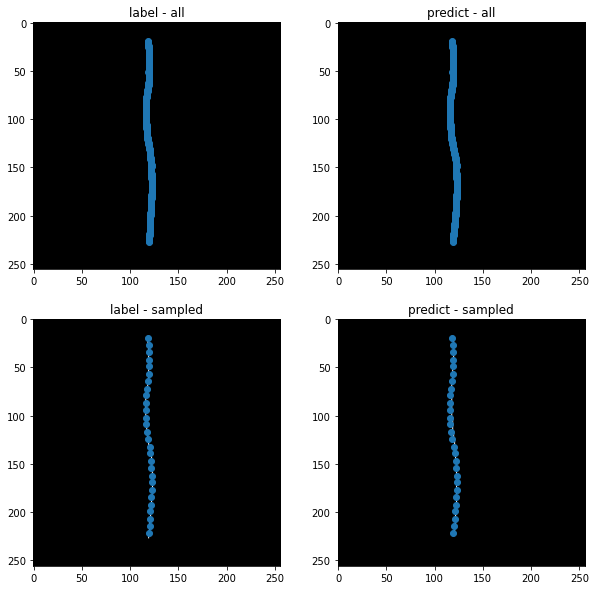

In [94]:
for data in pad_dataset:
  label = cv.imread(data['label_path'], cv.IMREAD_GRAYSCALE)
  label = cv.resize(label, (256, 256), interpolation = cv.INTER_AREA)
  point_x, point_y, sampled_point_x, sampled_point_y= get_feature_points(label)
  
  predict = cv.imread(data['predict_path'])
  p_point_x, p_point_y, p_sampled_point_x, p_sampled_point_y= get_feature_points(label)

  plt.figure(figsize=(10, 10))  
  plt.subplot(221)
  plt.scatter(point_x,point_y)  
  plt.imshow(label, cmap='gray')
  plt.title('label - all')

  plt.subplot(222)
  plt.scatter(p_point_x,p_point_y)  
  plt.imshow(predict, cmap='gray')
  plt.title('predict - all')

  plt.subplot(223)
  plt.scatter(sampled_point_x,sampled_point_y)  
  plt.imshow(label, cmap='gray')
  plt.title('label - sampled')


  plt.subplot(224)
  plt.scatter(p_sampled_point_x,p_sampled_point_y)  
  plt.imshow(predict, cmap='gray')
  plt.title('predict - sampled')
  break

# Extract Feature points from Pixel Value
#### 미영샘 추천 방법

In [15]:
import numpy as np

In [49]:
def get_points_locations(image):
  locations = np.nonzero(image)
  # y, x = locations[0], locations[1]
  # sampled_x, sampled_y = x[0::10], y[0::10]
  return np.array(locations)

In [82]:
def min_euclidean_distance(predict_points, label_points):
  # for p_point in predict_points:
  #   for l_point in label_points:
  dists = np.hypot(predict_points[:, 0, np.newaxis]-label_points[:, 0], 
                    predict_points[:, 1, np.newaxis]-label_points[:, 1])
  min_dist = np.min(dists, axis=1)
  minidx = np.argmin(dists, axis=1)

  return np.mean(min_dist)

Point가 적게 검출되는 이유는 curve를 잘 잡지 못해서로 생각된다,,

### False Positive(over 100) 개수<br/>
-> PadChest: 0

In [122]:
pad_total_distance = []
pad_total_coverage = []

for data in tqdm(pad_dataset):
  label = cv.imread(data['label_path'], cv.IMREAD_GRAYSCALE)
  label = cv.resize(label, (256, 256), interpolation = cv.INTER_AREA)
  label_points = get_points_locations(label)
  
  predict = cv.imread(data['predict_path'], cv.IMREAD_GRAYSCALE)
  predict_points = get_points_locations(predict)

  min_distance = min_euclidean_distance(label_points, predict_points)
  coverage = (len(predict_points[0])/len(label_points[0]))*100

  pad_total_distance.append(min_distance)
  pad_total_coverage.append(coverage)

print()
print(f'Mean of Minimum Euclidean Distance: {np.mean(pad_total_distance)}')
print(f'Accuracy of Feature points(Coverage): {np.mean(pad_total_coverage)}')

100%|██████████| 232/232 [00:13<00:00, 16.66it/s]


Mean of Minimum Euclidean Distance: 6.747613263456391
Accuracy of Feature points(Coverage): 80.50987202926676


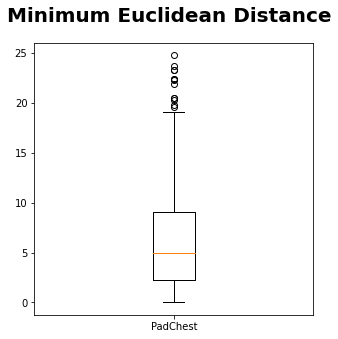

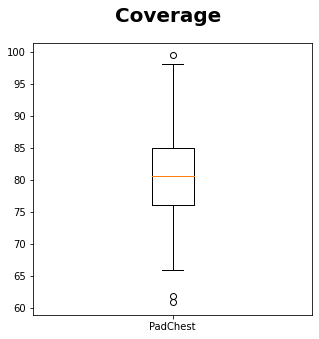

In [123]:
import seaborn as sns

fig = plt.figure(figsize=(5, 5))
fig.suptitle('Minimum Euclidean Distance', fontsize=20, fontweight='bold')
labels = ['PadChest']
# labels = ['PadChest', 'CheXpert']
bp_distance = plt.boxplot([pad_total_distance], labels=labels)

fig = plt.figure(figsize=(5, 5))
fig.suptitle('Coverage', fontsize=20, fontweight='bold')
labels = ['PadChest']
# labels = ['PadChest', 'CheXpert']
bp_coverage = plt.boxplot([pad_total_coverage], labels=labels)

In [ ]:
import pandas as pd

def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

## Minimum Euclidean Distance Boxplot Inform 출력

In [119]:
get_box_plot_data(labels, bp_distance)

,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,PadChest,0.0,2.257412,4.949747,9.037058,19.091883


## Coverage Boxplot Inform 출력

In [121]:
get_box_plot_data(labels, bp_coverage)

,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,PadChest,65.991903,76.106759,80.660044,85.004682,98.113208
